# Synthetic vs. real data comparison

In [11]:
import numpy as np
import jax.numpy as jnp
import jax

import jax.scipy as jsp
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from circuitmap import NeuralDemixer
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit

import sys
sys.path.append('../')
import grid_utils as util
import subtract_utils as subtract_utils
import os
import glob
import pc_subtractr_network
import jax.random as jrand
import photocurrent_sim
import h5py
import circuitmap as cm

plt.rcParams['figure.dpi'] = 300

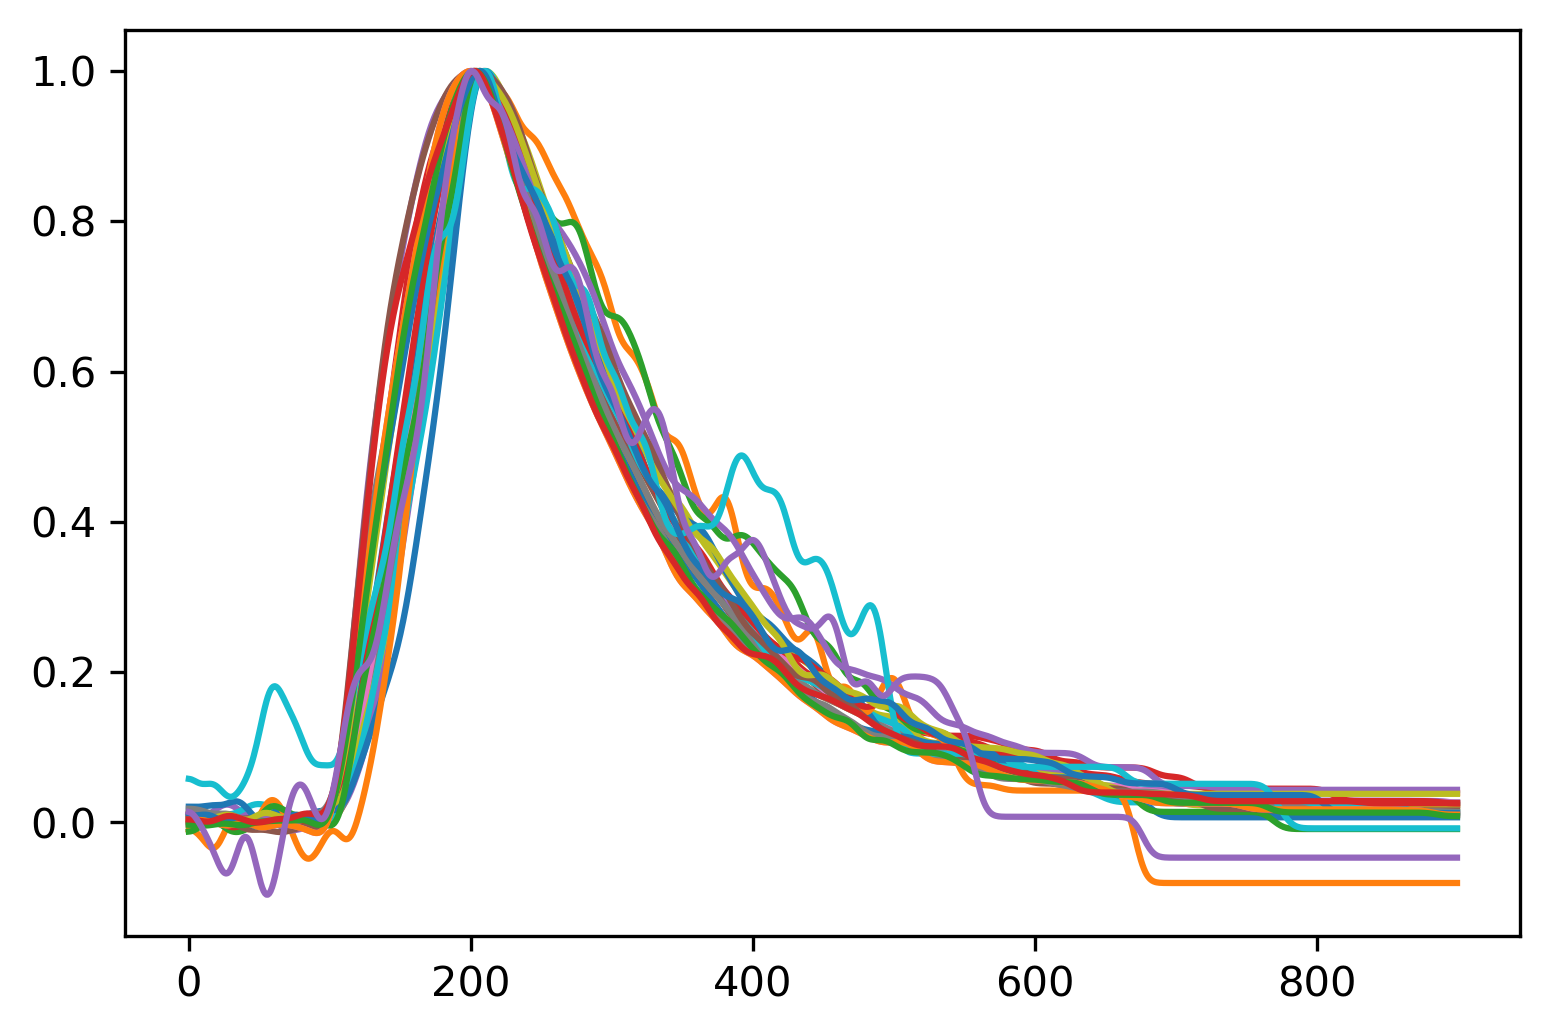

In [30]:
with h5py.File('../visualization/pc_examples_fastdecay.h5') as f:
    examples = np.array(f['traces'])
    
examples = cm.neural_waveform_demixing._monotone_decay_filter(examples)
examples = gaussian_filter1d(examples, sigma=6)
examples /= np.max(examples, keepdims=True, axis=-1)
plt.plot(examples.T)

## Manually pull traces of just photocurrent

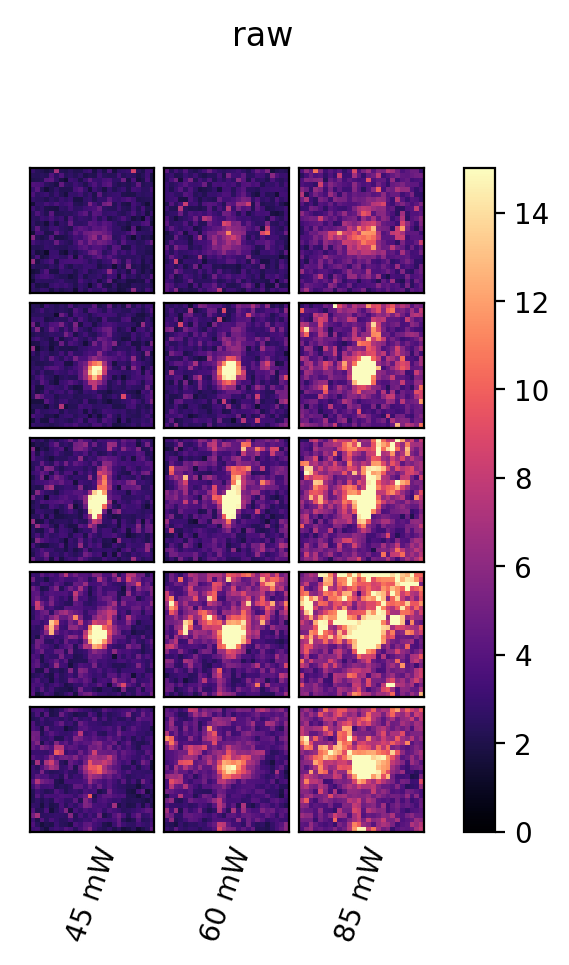

In [18]:
dataset_path = "../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220617_B6_Chrome2fGC8_IC_061722_Cell1_C_planes_cmReformat.mat"

pscs, stim_mat, powers, targets = util.load_h5_data(dataset_path)

raw_tensor = util.make_psc_tensor_multispot(pscs, powers, targets, stim_mat)
raw_map = subtract_utils.traces_tensor_to_map(raw_tensor)

num_planes = raw_map.shape[-1]
fig1 = plt.figure(figsize=(3, num_planes), dpi=200, facecolor='white')
util.plot_multi_means(fig1,
    [
        raw_map,
    ], 
    np.arange(num_planes),
    map_names=['raw', 'subtr.', 'demixed'],
    cmaps=['magma', 'magma', 'magma', 'magma'],
    # cbar_labels=['EPSQ (nC)'],
    # zlabels=['subtr', 'demix'],
    # map_names=['raw', 'subtr', 'demix'],
    vranges=[(0,15), (0,15), (0,15), (0,15)],
    powers=np.unique(powers),
    show_powers=(True, True, True, True)
)

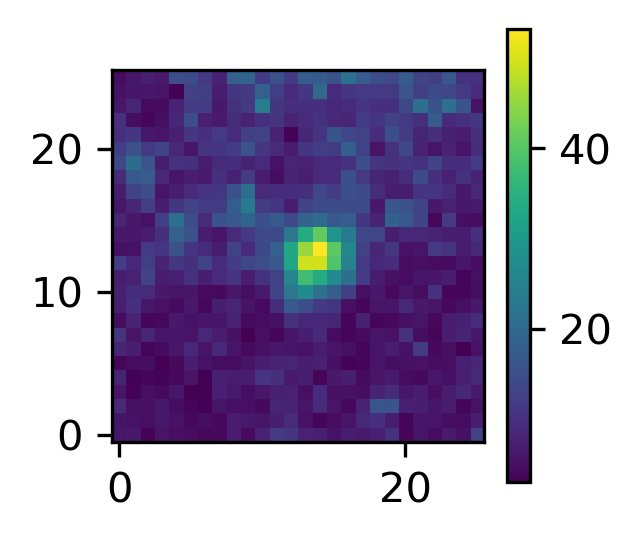

In [22]:
plt.figure(figsize=(2,2))
plt.imshow(raw_map[2, :, :, -2], origin='lower', )
plt.colorbar()

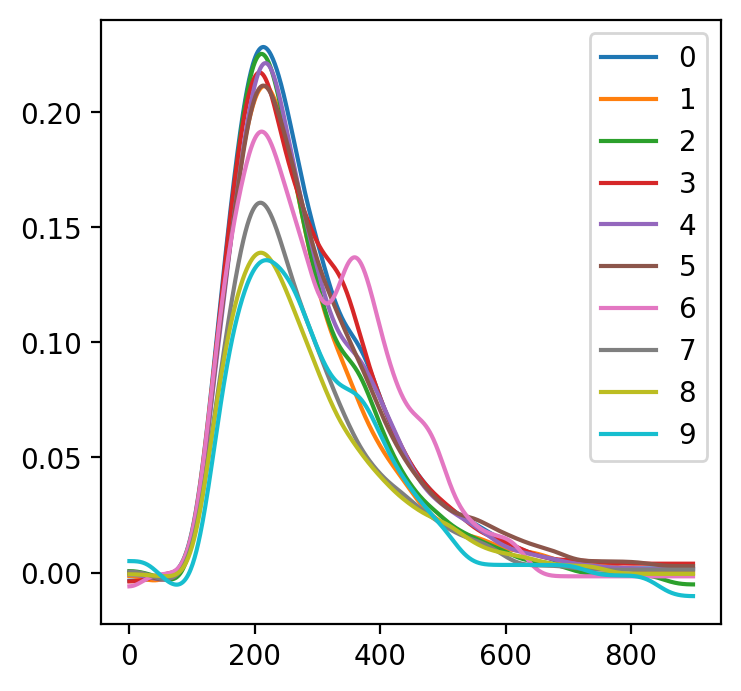

In [25]:
plt.figure(figsize=(4,4), dpi=200)
pc_traces = np.copy(raw_tensor[2, 12, 14, -2, :].reshape(-1, 900),)
cm.neural_waveform_demixing._monotone_decay_filter(pc_traces)
pc_traces = gaussian_filter1d(pc_traces, sigma=20)
pc_traces -= np.mean(pc_traces[:, 0:100], axis=-1, keepdims=True)
for i,x in enumerate(pc_traces):
    plt.plot(x, label=i)
plt.legend()

In [241]:
add_templates('templates.h5', pcs=pc_traces)

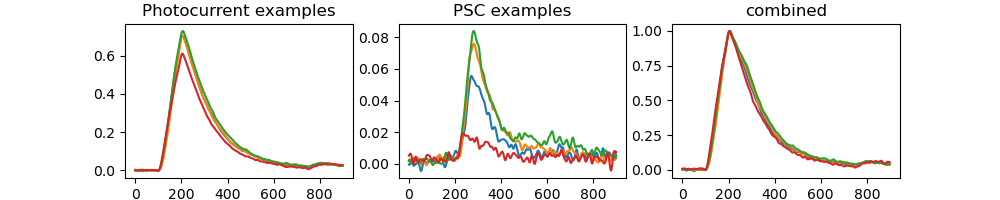

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,2))
combined = psc_traces + pc_traces
maxv = np.max(combined, axis=-1, keepdims=True)
combined /= (maxv + 1e-3)

axs[0].plot(pc_traces.T)
axs[0].set_title('Photocurrent examples')

axs[1].plot(psc_traces.T)
axs[1].set_title('PSC examples')

axs[2].plot(combined.T)
axs[2].set_title('combined')
plt.show()

## Create HDF5 dataset to store examples of photocurrents and pscs

In [54]:
with h5py.File('templates.h5', mode='a') as f:
    psc_dataset = f.create_dataset('psc_dataset', data=psc_traces, maxshape=(None, psc_traces.shape[-1]))
    pc_dataset = f.create_dataset('pc_dataset', data=pc_traces, maxshape=(None, psc_traces.shape[-1]))

In [97]:
# create a method to add new pscs and new PCs to our templates file
def add_templates(dataset_path, pscs=None, pcs=None, ):
    with h5py.File(dataset_path, mode='r+') as f:

        if pscs is not None:
            f['psc_dataset'].resize(
                (f['psc_dataset'].shape[0] + pscs.shape[0]), axis = 0)
            f['psc_dataset'][-pscs.shape[0]:, :] = pscs

        if pcs is not None:
            f['pc_dataset'].resize(
                (f['pc_dataset'].shape[0] + pcs.shape[0]), axis = 0)
            # add new templates
            f['pc_dataset'][-pcs.shape[0]:, :] = pcs

## grab traces from synaptic blocker dataset

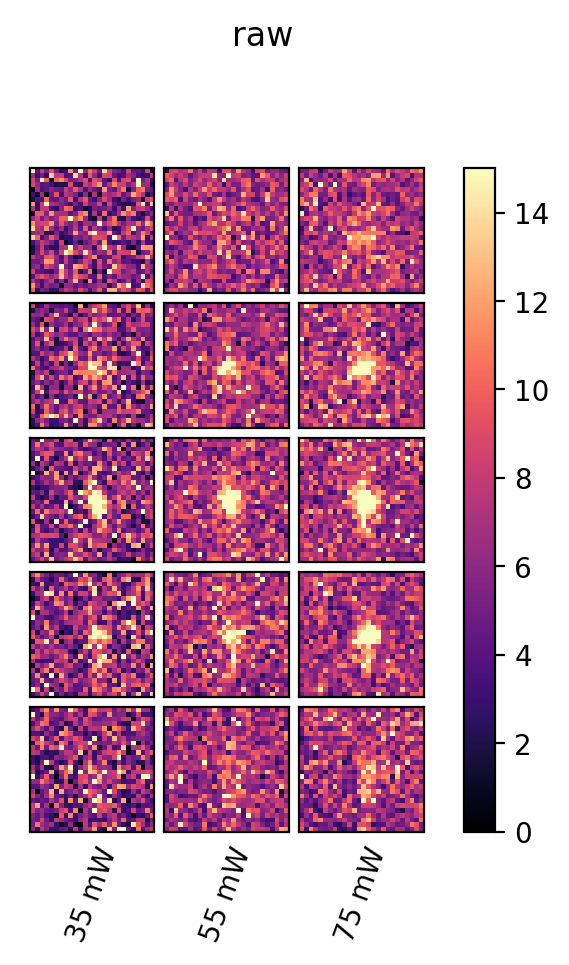

In [13]:
dataset_path = "../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220704_B6_Chrome2fGC8_IC_070422_Cell1_NBQX_A_planes_cmReformat.mat"

pscs, stim_mat, powers, targets = util.load_h5_data(dataset_path)

raw_tensor = util.make_psc_tensor_multispot(pscs, powers, targets, stim_mat)
raw_map = subtract_utils.traces_tensor_to_map(raw_tensor)

num_planes = raw_map.shape[-1]
fig1 = plt.figure(figsize=(3, num_planes), dpi=200, facecolor='white')
util.plot_multi_means(fig1,
    [
        raw_map,
    ], 
    np.arange(num_planes),
    map_names=['raw', 'subtr.', 'demixed'],
    cmaps=['magma', 'magma', 'magma', 'magma'],
    # cbar_labels=['EPSQ (nC)'],
    # zlabels=['subtr', 'demix'],
    # map_names=['raw', 'subtr', 'demix'],
    vranges=[(0,15), (0,15), (0,15), (0,15)],
    powers=np.unique(powers),
    show_powers=(True, True, True, True)
)

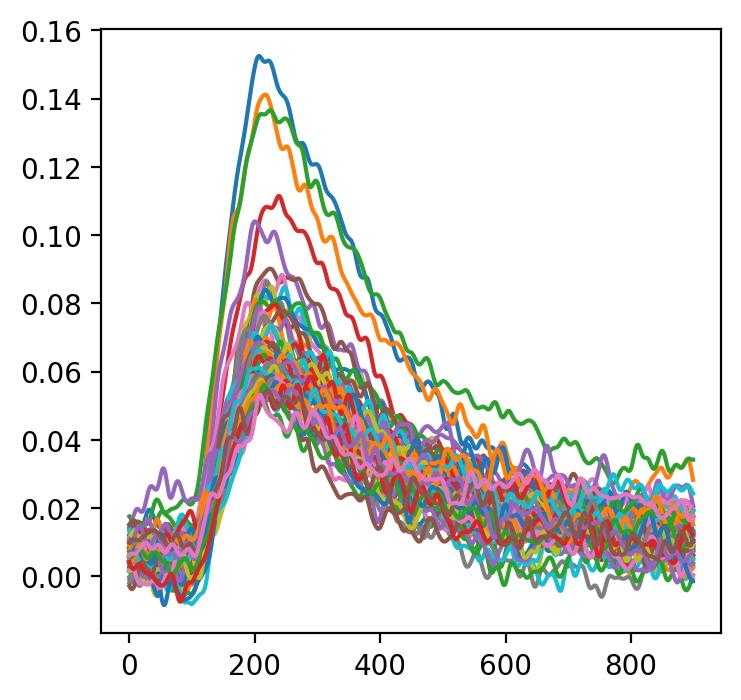

In [15]:
plt.figure(figsize=(4,4), dpi=200)
idxs = np.argsort(pscs[:,150:300].max(-1))[::-1]
pc_traces = pscs[idxs[0:100]]

# cm.neural_waveform_demixing._monotone_decay_filter(pc_traces)
# pc_traces = gaussian_filter1d(pc_traces, sigma=10)
# pc_traces -= np.mean(pc_traces[:, 0:100], axis=-1, keepdims=True)

# filter out traces where the end is constant
# valid_idxs = ~np.all(np.abs(np.diff(pc_traces[:, 800:900], axis=-1)) <= 1e-4, axis=-1)
valid_idxs = ~(pc_traces[:,0] > 0.02)

# filter out traces with large next-trial stim
valid_idxs = valid_idxs & ~(np.mean(np.diff(pc_traces[:, 725:785], axis=-1), axis=-1) > 0)

# filter out weird traces
valid_idxs = valid_idxs & ~(np.min(pc_traces, axis=-1) < -0.05)

pc_traces = pc_traces[valid_idxs]

plt.plot(pc_traces.T)
plt.show()

In [17]:
# store these curated traces in their own dataset
with h5py.File('synblocker_photocurrent_examples_shortdecay.h5', mode='a') as f:
    pc_dataset = f.create_dataset('traces', data=pc_traces)

## grab PSC templates from opsin negative cell

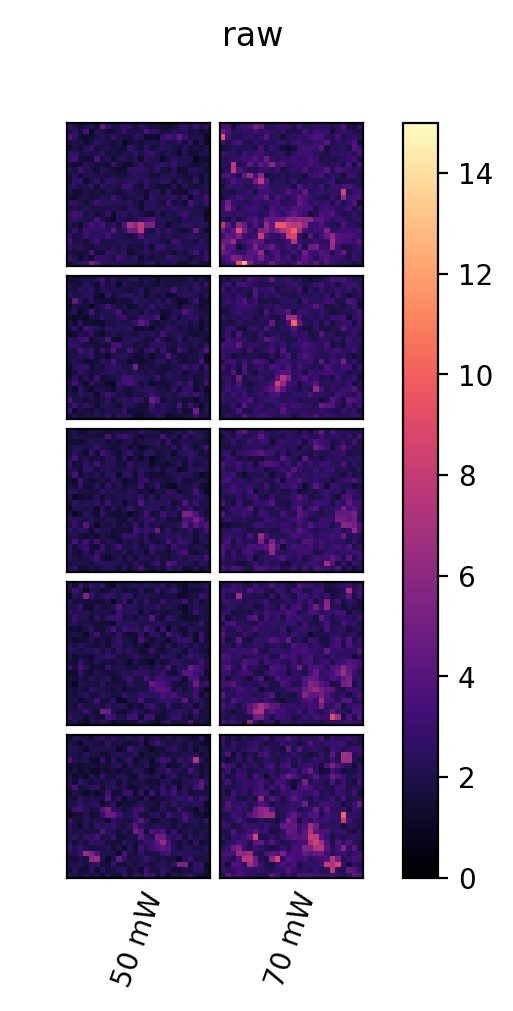

In [5]:
dataset_path = "../data/marta/ai203/preprocessed/201118_cell1_A_cmFormat.mat"


pscs, stim_mat, powers, targets = util.load_h5_data(dataset_path)

raw_tensor = util.make_psc_tensor_multispot(pscs, powers, targets, stim_mat)
raw_map = subtract_utils.traces_tensor_to_map(raw_tensor)

num_planes = raw_map.shape[-1]
fig1 = plt.figure(figsize=(3, num_planes), dpi=200, facecolor='white')
util.plot_multi_means(fig1,
    [
        raw_map,
    ], 
    np.arange(num_planes),
    map_names=['raw', 'subtr.', 'demixed'],
    cmaps=['magma', 'magma', 'magma', 'magma'],
    # cbar_labels=['EPSQ (nC)'],
    # zlabels=['subtr', 'demix'],
    # map_names=['raw', 'subtr', 'demix'],
    vranges=[(0,15), (0,15), (0,15), (0,15)],
    powers=np.unique(powers),
    show_powers=(True, True, True, True)
)


In [6]:
# since this cell is opsin positive (but weak) we can take data from the first two planes
# as psc examples 

In [7]:
psc_traces = np.copy(raw_tensor[:, :, :, 0:3, :]).reshape(-1, 900)


In [8]:
with h5py.File('psc_templates.h5', 'a') as f:
    f.create_dataset('traces', data=psc_traces)


In [123]:
add_templates('templates.h5', pscs=psc_traces)

## inspect files with saved pscs and pcs

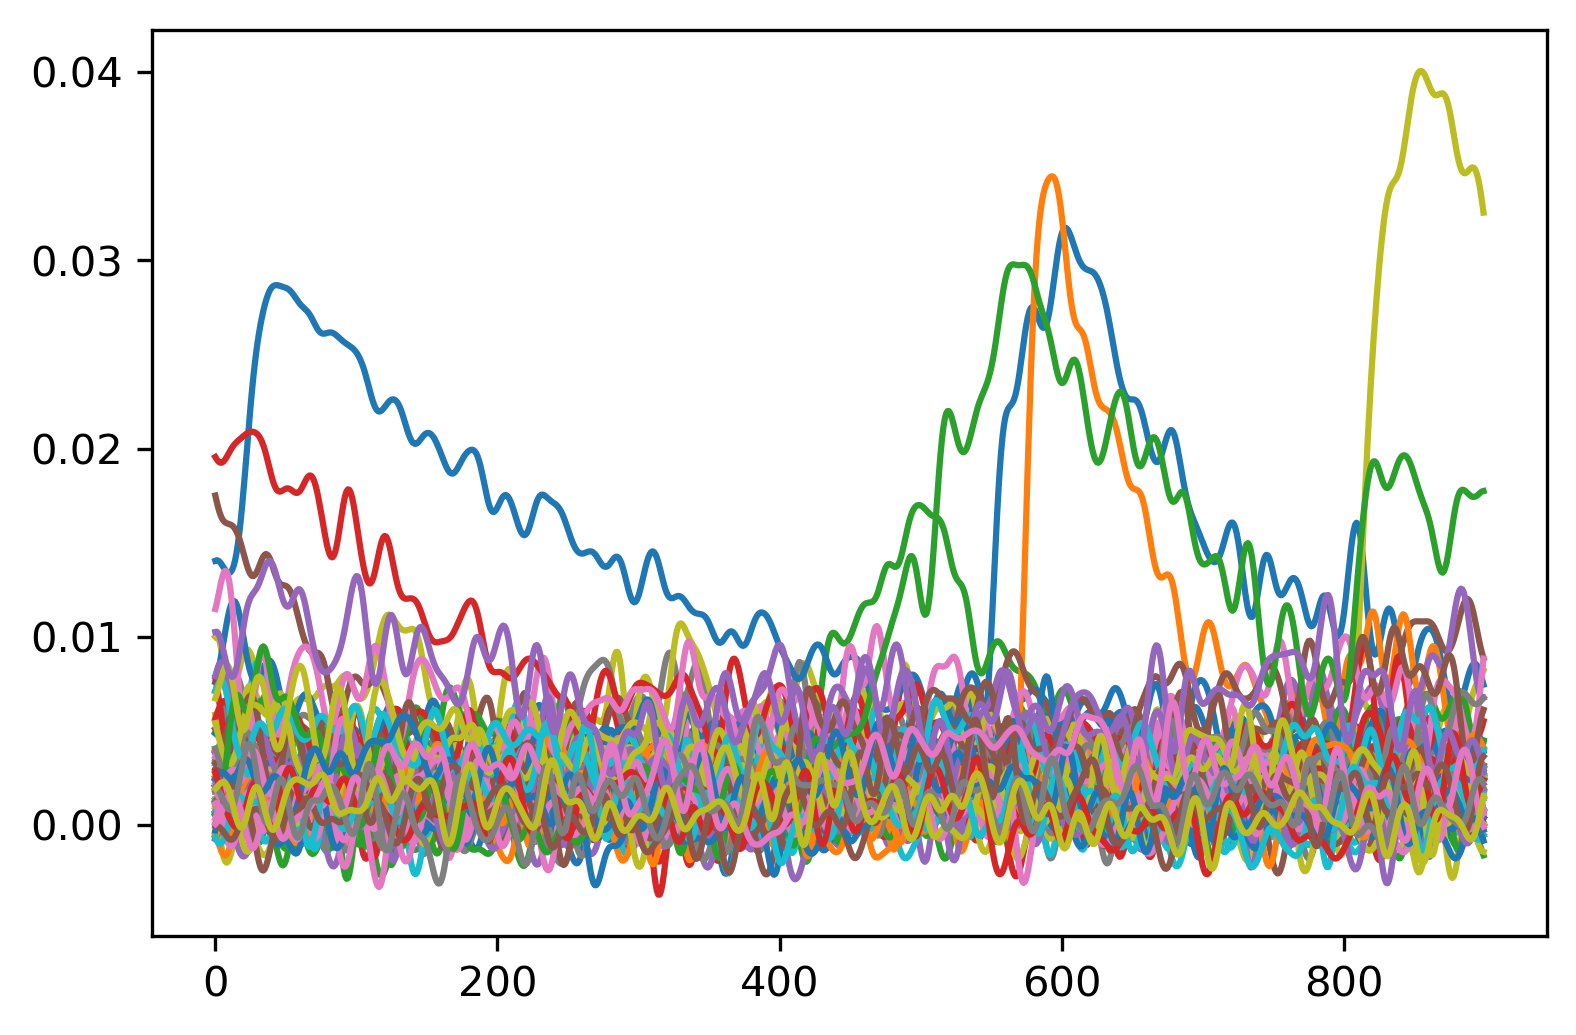

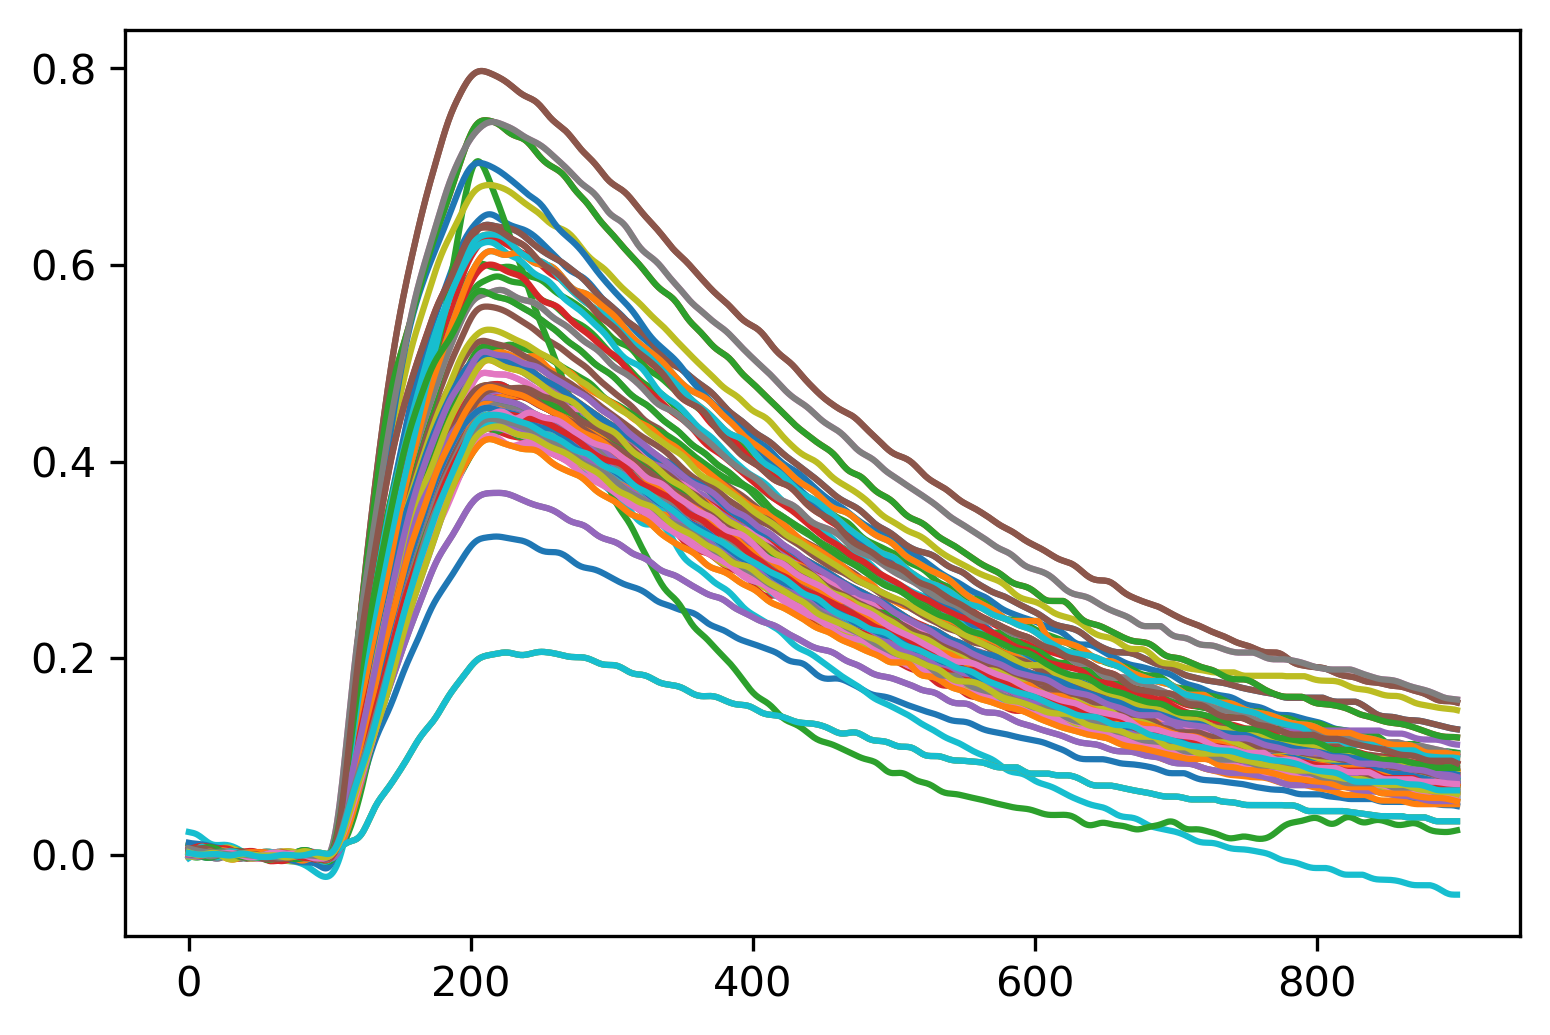

In [10]:
with h5py.File('pc_templates.h5', mode='r') as f:
    pc_templates = np.array(f['traces'])

with h5py.File('psc_templates.h5', mode='r') as f:
    psc_templates = np.array(f['traces'])
    
plt.figure()
idxs = np.random.randint(0, psc_templates.shape[0], size=100)
plt.plot(psc_templates[idxs].T)

plt.figure()
idxs = np.random.randint(0, pc_templates.shape[0], size=100)
plt.plot(pc_templates[idxs].T)